In [1]:
import pandas as pd

Посмотрим на поля представленного датасета

In [2]:
data = pd.read_json('data/banki_responses.json', lines=True)

In [3]:
data.head(3)

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Воронеж,True,Ипотека на 5+,0,лицензия № 1623,e.novikova,ВТБ 24,2015-06-08 11:06:56,Здравствуйте! Хотелось бы выразить благодарно...,5.0
1,г. Казань,True,ЗВОНКИ СОСЕДЯМ,0,лицензия № 2289,KZN\Vorontsova_NA,Русский Стандарт,2015-06-06 18:17:52,Уважаемые представители департамента по работе...,2.0
2,г. Санкт-Петербург,True,Ложная информация!!!!,0,лицензия № 2307,Evgenia15,Союз,2015-06-07 19:08:33,Здравствуйте. Столкнулась с такой ситуацией. в...,2.0


In [4]:
data[data.rating_not_checked==False].head(3)

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
5,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
6,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
11,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN


Загрузим отзывы не прошедшие оценку (прям из архива)

In [3]:
import bz2
from tqdm import tqdm #индикатор прогресса
import json

In [4]:
responses = []
with bz2.BZ2File('data/banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [01:23, 2410.18it/s]


In [7]:
responses[2]

{'city': 'г. Москва',
 'rating_not_checked': False,
 'title': 'Двойное списание за один товар.',
 'num_comments': 1,
 'bank_license': 'лицензия № 2562',
 'author': 'Vladimir84',
 'bank_name': 'Бинбанк',
 'datetime': '2015-06-05 20:14:28',
 'text': 'Здравствуйте! \xa0Дублирую свое заявление от 03.06.2015 в ДО "Можайский". \xa002.06.2015 мною, по моей дебетовой карте была совершена покупка в интернет-магазине \xa0на сумму 3028 руб., но с карты произошло двойное списание (два раза по 3028 руб.) то есть 6056 руб. (о чем имеются смс сообщения от банка). Интернет-магазин подтвердил только один платеж 3028 руб. , товар был получен 05.06.2015. Прошу разобраться в ситуации и вернуть мне на счет ошибочно списанную сумму в размере 3028 руб.!  \xa0С уважением, давний клиент Вашего банка Владимир. Номер карты указан в моем заявлении в\xa0ДО "Можайский".',
 'rating_grade': None}

## Классифицировать по тональности отзывы на банки с сайта banki.ru

Основной целью анализа тональности является нахождение мнений в тексте и выявление их свойств. Цель - произвести синтаксический анализ документов. Можно использовать UDPipe.

In [8]:
!pip3 install ufal.udpipe

Качаем уже обученную модель

In [9]:
!wget https://github.com/jwijffels/udpipe.models.ud.2.0/raw/master/inst/udpipe-ud-2.0-170801/russian-ud-2.0-170801.udpipe

--2021-03-07 13:38:05--  https://github.com/jwijffels/udpipe.models.ud.2.0/raw/master/inst/udpipe-ud-2.0-170801/russian-ud-2.0-170801.udpipe
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jwijffels/udpipe.models.ud.2.0/master/inst/udpipe-ud-2.0-170801/russian-ud-2.0-170801.udpipe [following]
--2021-03-07 13:38:06--  https://raw.githubusercontent.com/jwijffels/udpipe.models.ud.2.0/master/inst/udpipe-ud-2.0-170801/russian-ud-2.0-170801.udpipe
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13265262 (13M) [application/octet-stream]
Saving to: ‘russian-ud-2.0-170801.udpipe.1’

russian-ud-2.0-1708 1

In [5]:
from ufal.udpipe import Model, Pipeline

In [6]:
#загружаем готовую обученную модель
model = Model.load('russian-ud-2.0-170801.udpipe')
model

<Swig Object of type 'model *' at 0x7fa8e8b11770>

In [7]:
#указываем токенизатор с которыми будем работать
pipeline = Pipeline(model, 'generic_tokenizer', '', '', '')

In [13]:
responses[2]['text']

'Здравствуйте! \xa0Дублирую свое заявление от 03.06.2015 в ДО "Можайский". \xa002.06.2015 мною, по моей дебетовой карте была совершена покупка в интернет-магазине \xa0на сумму 3028 руб., но с карты произошло двойное списание (два раза по 3028 руб.) то есть 6056 руб. (о чем имеются смс сообщения от банка). Интернет-магазин подтвердил только один платеж 3028 руб. , товар был получен 05.06.2015. Прошу разобраться в ситуации и вернуть мне на счет ошибочно списанную сумму в размере 3028 руб.!  \xa0С уважением, давний клиент Вашего банка Владимир. Номер карты указан в моем заявлении в\xa0ДО "Можайский".'

In [8]:
parsed = pipeline.process(responses[2]['text'])

In [15]:
print(parsed)

# newdoc
# newpar
# sent_id = 1
# text = Здравствуйте!
1	Здравствуйте	Здравствуйте	ADV	RB	_	0	root	_	SpaceAfter=No
2	!	!	PUNCT	.	_	1	punct	_	SpacesAfter=\s 

# sent_id = 2
# text = Дублирую свое заявление от 03.06.2015 в ДО "Можайский". 02.06.2015 мною, по моей дебетовой карте была совершена покупка в интернет-магазине на сумму 3028 руб., но с карты произошло двойное списание (два раза по 3028 руб.) то есть 6056 руб. (о чем имеются смс сообщения от банка).
1	Дублирую	Дублирую	PRON	AWP	Animacy=Inan|Case=Acc|Gender=Fem|Number=Sing	51	obj	_	_
2	свое	СВОЙ	DET	PRP$	Animacy=Inan|Case=Acc|Gender=Neut|Number=Sing|Reflex=Yes	3	det	_	_
3	заявление	ЗАЯВЛЕНИЕ	NOUN	NN	Animacy=Inan|Case=Acc|Gender=Neut|Number=Sing	1	obj	_	_
4	от	ОТ	ADP	IN	_	17	case	_	_
5	03.06	03.06	NUM	CD	Case=Nom|NumType=Card	17	nsubj	_	SpaceAfter=No
6	.	.	PUNCT	.	_	17	punct	_	SpaceAfter=No
7	2015	2015	NUM	CD	Case=Nom|NumType=Card	17	nummod:gov	_	_
8	в	В	ADP	IN	_	9	case	_	_
9	ДО	до	PROPN	NNP	Animacy=Inan|Case=Loc|Gender=Neut|Numbe

Разделил на предложения (токенизатор сработал верно). Произвел синтаксический анализ. Извлек морфологические признаки. 

#### Посчитайте количество отзывов в разных городах и на разные банки

In [9]:
cities = {}
for response in responses:
    if response['city'] in cities:
        cities[response['city']] += 1
    else:
        cities[response['city']] = 0

In [10]:
banks = {}
for response in responses:
    if response['bank_name'] in banks:
        banks[response['bank_name']] += 1
    else:
        banks[response['bank_name']] = 0

#### Постройте гистограмы длин слов в символах

In [11]:
lens = {}
for response in responses:
    if len(response['text']) in lens:
        lens[len(response['text'])] += 1
    else:
        lens[len(response['text'])] = 0

(0.0, 7000.0)

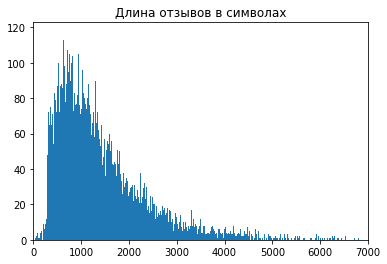

In [12]:
import matplotlib.pyplot as plt

plt.bar(lens.keys(), lens.values(), width=1)
plt.title('Длина отзывов в символах')
plt.xlim(0,7000)

#### Постройте гистограмы длин слов в словах

In [13]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize 

for response in tqdm(responses):
    #токенизируем по словам
    response['text'] = word_tokenize(response['text'])
    #isalnum() вернёт True, если в строке хотя бы один символ и все символы строки являются цифрами и/или буквами, иначе — False.
    response['text'] = [word for word in response['text'] if word.isalnum()]

[nltk_data] Downloading package punkt to /home/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
100%|██████████| 153499/153499 [05:32<00:00, 461.69it/s]


In [14]:
response['text'][:5]

['Если', 'коротко', 'то', 'мне', 'нравится']

In [15]:
lens = {}
for response in responses:
    if len(response['text']) in lens:
        lens[len(response['text'])] += 1
    else:
        lens[len(response['text'])] = 0

(0.0, 1500.0)

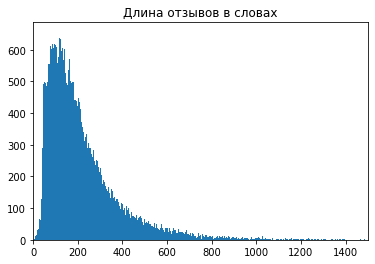

In [16]:
plt.bar(lens.keys(), lens.values(), width=1)
plt.title('Длина отзывов в словах')
plt.xlim(0,1500)

#### Найдите 10 самых частых слов

In [17]:
words = {}
for response in tqdm(responses):
    for word in response['text']:
        word = word.lower()
        if word in words:
            words[word] += 1
        else:
            words[word] = 0

words = {k: v for k, v in sorted(words.items(), key=lambda item: item[1], reverse=True)}

print('10 самых популярных слов: ', list(words.keys())[:10])

100%|██████████| 153499/153499 [00:16<00:00, 9062.94it/s] 


10 самых популярных слов:  ['в', 'и', 'не', 'на', 'что', 'я', 'с', 'по', 'мне', 'банка']


#### Найдите 10 самых частых слов без стоп-слов

Стоп слова - это слова, знаки, символы, которые самостоятельно не несут никакой смысловой нагрузки, но которые, тем не менее, совершенно необходимы для нормального восприятия текста.

In [15]:
from nltk.corpus import stopwords 
nltk.download('stopwords')

stop_words = set(stopwords.words('russian'))
stopwords.words('russian')[:10]

[nltk_data] Downloading package stopwords to /home/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со']

In [19]:
words_no_stop = {}

for word, count in words.items():
    if word not in stop_words:
        words_no_stop[word] = count
        
print('10 самых популярных слов без стоп-слов: ', list(words_no_stop.keys())[:10])

10 самых популярных слов без стоп-слов:  ['банка', 'банк', 'это', 'деньги', 'карту', 'карты', 'кредит', 'день', 'заявление', 'отделение']


In [20]:
# очистка стоп слов для дальнейщей работы
for response in tqdm(responses):
    response['text'] = [word for word in response['text'] if word not in stop_words]

100%|██████████| 153499/153499 [00:03<00:00, 44409.62it/s]


#### Найдите 10 самых частых лемм и существительных

In [30]:
!pip3 install pymorphy2

In [6]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [45]:
morph.parse('банка')

[Parse(word='банка', tag=OpencorporaTag('NOUN,inan,masc sing,gent'), normal_form='банк', score=0.954545, methods_stack=((DictionaryAnalyzer(), 'банка', 19, 1),)),
 Parse(word='банка', tag=OpencorporaTag('NOUN,inan,femn sing,nomn'), normal_form='банка', score=0.045454, methods_stack=((DictionaryAnalyzer(), 'банка', 8, 0),))]

In [54]:
morph.parse('банка')[0].normal_form

'банк'

In [22]:
words_lemma = {}
words_noun = {}

for word, count in tqdm(words_no_stop.items()):
    lemma = morph.parse(word)[0]
    if lemma.normal_form in words_lemma:
        words_lemma[lemma.normal_form] += count
    else:
        words_lemma[lemma.normal_form] = count
        
    if 'NOUN' in lemma.tag:
        if lemma.normal_form in words_noun:
            words_noun[lemma.normal_form] += count
        else:
            words_noun[lemma.normal_form] = count

words_lemma = {k: v for k, v in sorted(words_lemma.items(), key=lambda item: item[1], reverse=True)}
words_noun = {k: v for k, v in sorted(words_noun.items(), key=lambda item: item[1], reverse=True)}

100%|██████████| 316042/316042 [00:40<00:00, 7753.31it/s]


In [55]:
print('10 самых популярных лемм: ', list(words_lemma.keys())[:10])

10 самых популярных лемм:  ['банк', 'карта', 'это', 'деньга', 'день', 'мой', 'кредит', 'который', 'отделение', 'счёт']


In [56]:
print('10 самых популярных существительных: ', list(words_noun.keys())[:10])

10 самых популярных существительных:  ['банк', 'карта', 'деньга', 'день', 'кредит', 'отделение', 'счёт', 'сотрудник', 'клиент', 'сумма']


### Кривая Ципфа 

Эмпирическая закономерность распределения частоты слов естественного языка: если все слова текста упорядочить по убыванию частоты их использования, то частота n-го слова в таком списке окажется приблизительно обратно пропорциональной его порядковому номеру n. 

Например, второе по используемости слово встречается примерно в два раза реже, чем первое, третье — в три раза реже, чем первое, и так далее. 

(0.0, 6000.0)

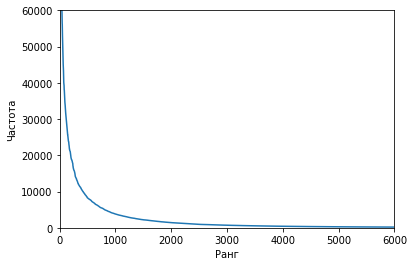

In [23]:
import numpy as np

cipfa = [x for x in words_lemma.values()]

plt.plot(cipfa)

plt.ylabel('Частота')
plt.xlabel('Ранг')
plt.ylim(0,60000)
plt.xlim(0,6000)

### Кривая Хипса

Эмпирическая закономерность в лингвистике, описывающая распределение числа уникальных слов в документе (или наборе документов) как функцию от его длины. C увеличением длины текста (количества токенов), количество типов увеличивается.

In [143]:
len_text = {}

for response in responses:
    len_text[len(response['text'])] = len(set(response['text']))    

In [144]:
import collections

len_text_sort = collections.OrderedDict(sorted(len_text.items()))

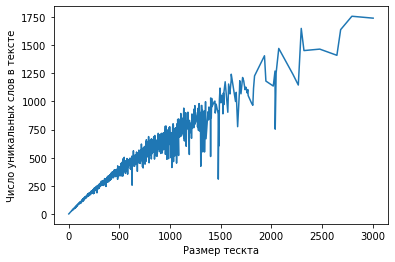

In [145]:
plt.ylabel('Число уникальных слов в тексте')
plt.xlabel('Размер тескта')

plt.plot(len_text_sort.keys(), len_text_sort.values())

Не хватает экспоненциального сглаживания. Добавим.

In [152]:
len_text_sort.update((key, 100*val**0.4) for key, val in len_text_sort.items())

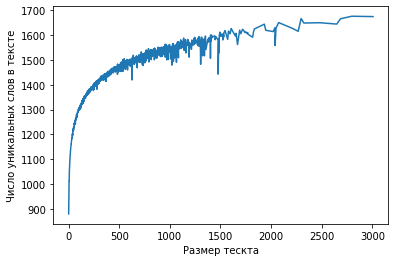

In [153]:
plt.ylabel('Число уникальных слов в тексте')
plt.xlabel('Размер тескта')

plt.plot(len_text_sort.keys(), len_text_sort.values())

#### Какое слово встречается чаще, "сотрудник" или "клиент"?

In [81]:
print('Слово "сотрудник" встречается чаще чем "клиент": ', words_lemma['сотрудник'] > words_lemma['клиент'])

Слово "сотрудник" встречается чаще чем "клиент":  True


#### Сколько раз встречается слова "мошенничество" и "доверие"?

In [84]:
print('Слово "мошенничество" встречается {} раз'.format(words_lemma['мошенничество']))

Слово "мошенничество" встречается 3220 раз


In [85]:
print('Слово "доверие" встречается {} раз'.format(words_lemma['доверие']))

Слово "доверие" встречается 2092 раз


#### Найдите ключевые слова и биграмы для положительных и отрицальных отзывов

In [155]:
negative = data['text'][data.rating_grade==1.0]
positive = data['text'][data.rating_grade==5.0]

In [156]:
negative

3         1 июня 2015 в Москве в отделении по адресу Смо...
4         История очень долгая! Пришел я в банк (это раз...
10        В ИнтерБыстробанке удобно оплачивать ком. плат...
12        Вы хотя бы читали что пишут те, кому вы обязан...
13        Здравствуйте. Сразу скажу что отношение к сбер...
                                ...                        
201015    И я должен за овердрафт 1458 рублей, а карту т...
201021    Ситуация как и у всех - ни разу не воспользова...
201024    Оформил в банке кредитную карту в январе 2004 ...
201027    Уважаемое руководство банка «ОВК»! Я проживаю ...
201028    Пробовала 10.04.05 оформить товар в кредит в А...
Name: text, Length: 72307, dtype: object

In [95]:
positive

0         Здравствуйте!  Хотелось бы выразить благодарно...
9         Хочу поблагодарить Надежду из отдела по ипотеч...
31        Выплату из АСВ по Транспортному Банку пошел по...
40        В Куйбышевском филиале, в головном офисе прост...
84        Хочу выразить огромную благодарность сотрудник...
                                ...                        
201019    Пользуюсь банком 3 месяца - специально открыл ...
201020    А что писать? Ставки по вкладам высокие (до 13...
201022    А я с мужем обставила техникой совершенно нову...
201025    Слишком большой банк, не всегда учитывает нашу...
201029    Если коротко, то мне нравится. Кридит получать...
Name: text, Length: 26715, dtype: object

In [157]:
merge = negative.append(positive)

In [99]:
merge 

3         1 июня 2015 в Москве в отделении по адресу Смо...
4         История очень долгая! Пришел я в банк (это раз...
10        В ИнтерБыстробанке удобно оплачивать ком. плат...
12        Вы хотя бы читали что пишут те, кому вы обязан...
13        Здравствуйте. Сразу скажу что отношение к сбер...
                                ...                        
201019    Пользуюсь банком 3 месяца - специально открыл ...
201020    А что писать? Ставки по вкладам высокие (до 13...
201022    А я с мужем обставила техникой совершенно нову...
201025    Слишком большой банк, не всегда учитывает нашу...
201029    Если коротко, то мне нравится. Кридит получать...
Name: text, Length: 99022, dtype: object

In [158]:
from sklearn.feature_extraction.text import TfidfVectorizer
#слова
tfidf = TfidfVectorizer(analyzer='word')
tfidf_matrix = tfidf.fit_transform(merge)

In [159]:
#биграмы
tfidf = TfidfVectorizer(ngram_range=(2, 2))
tfidf_matrix = tfidf.fit_transform(merge)

## Тематическое моделирование

#### Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.

Gensim — библиотека обработки естественного языка предназначения для «Тематического моделирования».
С его помощью можно обрабатывать тексты, работать с векторными моделями слов (такими как Word2Vec, FastText и т. д.) и создавать тематические модели текстов.

In [163]:
merge

3         1 июня 2015 в Москве в отделении по адресу Смо...
4         История очень долгая! Пришел я в банк (это раз...
10        В ИнтерБыстробанке удобно оплачивать ком. плат...
12        Вы хотя бы читали что пишут те, кому вы обязан...
13        Здравствуйте. Сразу скажу что отношение к сбер...
                                ...                        
201019    Пользуюсь банком 3 месяца - специально открыл ...
201020    А что писать? Ставки по вкладам высокие (до 13...
201022    А я с мужем обставила техникой совершенно нову...
201025    Слишком большой банк, не всегда учитывает нашу...
201029    Если коротко, то мне нравится. Кридит получать...
Name: text, Length: 99022, dtype: object

In [271]:
# Токенизируем документы в слова
texts = [[text for text in doc.split()] for doc in merge]

Чтобы работать с текстовыми документами, Gensim требует, чтобы слова (или как еще их называют в данном случае токены) были преобразованы в уникальные идентификаторы. Для этого в Gensim необходимо создать объект Dictionary, который сопоставит каждое слово с уникальным идентификатором.

Преобразуем текст или предложения в [список слов] и передадим этот список объекту corpora.Dictionary()

In [169]:
from gensim import corpora

dictionary = corpora.Dictionary(texts)

In [170]:
print(dictionary)

Dictionary(817367 unique tokens: ['(5х5000руб.).', '000', '1', '10', '2015']...)


Gensim будет использовать этот словарь для создания корпуса, в котором слова в документах заменяются соответствующим идентификатором, предоставленным этим словарем.

Тематическое моделирование может выполняться с помощью таких алгоритмов, как скрытое распределение Дирихле (LDA) и скрытое семантическое индексирование (LSI).

In [178]:
#Для лемматизации, gensim использует пакет pattern
!pip3 install pattern

     |████████████████████████████████| 22.2 MB 954 kB/s eta 0:00:01
     |████████████████████████████████| 419 kB 24.8 MB/s eta 0:00:01
     |████████████████████████████████| 80 kB 8.8 MB/s  eta 0:00:01
     |████████████████████████████████| 5.6 MB 21.0 MB/s eta 0:00:01
     |████████████████████████████████| 5.5 MB 13.0 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 14.2 MB/s eta 0:00:01
  Created wheel for pattern: filename=Pattern-3.6-py3-none-any.whl size=22332723 sha256=2771fb1d0b39784dc81e759273c0d5e257ec0fc2eccd4c7c52c9bac947631f94
  Stored in directory: /home/user/.cache/pip/wheels/ec/ce/8f/bccc2d04f3a25a5a1dd19165b2855ad3203975f25edd5838d6
  Created wheel for python-docx: filename=python_docx-0.8.10-py3-none-any.whl size=184489 sha256=4096baf334f1a6643092876124b15c974c36af8e86c2c921fe793ddff1411971
  Stored in directory: /home/user/.cache/pip/wheels/97/4c/2e/68066cbf12b9b2e66403da8982aaf4f656d9f5cb5dc3179e82
  Created wheel for sgmllib3k: filename=sgmllib3k

Подготовим данные удаляя стоп лосы и лемматизируя их

In [273]:
from gensim.utils import lemmatize

data_processed = []

for text in texts[:2]:
    for wd in text:
        if wd not in list(stop_words):  # remove stopwords
            lemmatized_word = lemmatize(wd)  # lemmatize
            if lemmatized_word:
                doc_out = doc_out + [lemmatized_word[0].split(b'/')[0].decode('utf-8')]
        else:
            continue
data_processed.append(doc_out)

In [224]:
print(data_processed)

[['июня', 'москве', 'отделении', 'адресу', 'смоленская', 'площадь', 'около', 'счет', 'внесены', 'средства', 'размере', 'рублей', 'конце', 'операции', 'банкомат', 'завис', 'зачисления', 'произошло', 'позвонил', 'ситифон', 'назвал', 'номер', 'банкомата', 'адрес', 'время', 'внесения', 'средств', 'номинал', 'количество', 'купюр', 'руб', 'сотрудник', 'банка', 'заверил', 'течение', 'банковских', 'дней', 'моему', 'заявлению', 'проведено', 'расследование', 'результате', 'которого', 'сообщат', 'спустя', 'дней', 'июня', 'пришел', 'ответ', 'банка', 'котором', 'сообщалось', 'моему', 'заявлению', 'проведено', 'предварительное', 'расследование', 'результате', 'которого', 'деньги', 'найдены', 'были', 'банком', 'инициировано', 'дополнительное', 'расследование', 'срок', 'дней', 'снова', 'обратился', 'ситифон', 'просьбой', 'объяснить', 'причину', 'отрицательного', 'ответа', 'моему', 'заявлению', 'очевидно', 'инкассация', 'банкомата', 'состоялась', 'мои', 'вопросы', 'сотрудник', 'банка', 'отвечал', 'таки

data_processed теперь обрабатывается как список слов. Буду использовать его для создания словаря и корпуса, которые затем будут использоваться в качестве входных данных для модели LDA

In [225]:
dct = corpora.Dictionary(data_processed)
corpus = [dct.doc2bow(line) for line in data_processed]

In [227]:
from gensim.models import LdaMulticore

lda_model = LdaMulticore(corpus=corpus,
                         id2word=dct,
                         random_state=100,
                         num_topics=7,
                         passes=10,
                         chunksize=1000,
                         batch=False,
                         alpha='asymmetric',
                         decay=0.5,
                         offset=64,
                         eta=None,
                         eval_every=0,
                         iterations=100,
                         gamma_threshold=0.001,
                         per_word_topics=True)
# Сохраняю модель
lda_model.save('lda_model.model')
# Lda_model.print_topics показывает, какие слова внесли вклад в какую из 7 тем, а также вес вклада слова в эту тему.
lda_model.print_topics(-1)

[(0,
  '0.006*"результате" + 0.006*"отвечают" + 0.005*"расцениваю" + 0.005*"снова" + 0.005*"технической" + 0.005*"камер" + 0.005*"карты" + 0.005*"марта" + 0.005*"получить" + 0.005*"проводил"'),
 (1,
  '0.006*"заявления" + 0.005*"дней" + 0.005*"средств" + 0.005*"сбои" + 0.005*"карте" + 0.005*"они" + 0.005*"это" + 0.005*"моему" + 0.005*"карты" + 0.005*"около"'),
 (2,
  '0.006*"это" + 0.006*"сказали" + 0.005*"дней" + 0.005*"банка" + 0.005*"банк" + 0.005*"расследование" + 0.005*"моему" + 0.005*"около" + 0.005*"банкомат" + 0.005*"кассу"'),
 (3,
  '0.019*"дней" + 0.016*"банка" + 0.016*"банк" + 0.016*"это" + 0.013*"счет" + 0.013*"карты" + 0.010*"июня" + 0.010*"заявлению" + 0.010*"расследование" + 0.010*"звонка"'),
 (4,
  '0.005*"приехать" + 0.005*"инкассация" + 0.005*"моему" + 0.005*"являюсь" + 0.005*"самих" + 0.005*"просто" + 0.005*"было" + 0.005*"банкомат" + 0.005*"незаплаченная" + 0.005*"зоне"'),
 (5,
  '0.005*"переводиться" + 0.005*"которой" + 0.005*"спустя" + 0.005*"сотрудник" + 0.005*"ч

Некоторые слова, например "это", стоит добавить к stop words

In [257]:
#топ тем
lda_model.top_topics(corpus)[:2]

[([(0.0056036976, 'результате'),
   (0.005542811, 'отвечают'),
   (0.0054233037, 'расцениваю'),
   (0.0053828, 'снова'),
   (0.0052736755, 'технической'),
   (0.005128622, 'камер'),
   (0.0051198564, 'карты'),
   (0.0051172352, 'марта'),
   (0.005105279, 'получить'),
   (0.0050243917, 'проводил'),
   (0.0050185695, 'другую'),
   (0.004988739, 'назвал'),
   (0.0049561975, 'зарплатная'),
   (0.0049499245, 'было'),
   (0.004932078, 'номер'),
   (0.0049110632, 'банк'),
   (0.0048950864, 'были'),
   (0.0048828404, 'история'),
   (0.004877265, 'одни'),
   (0.0048676706, 'прошел')],
  1.0000889005818406e-12),
 ([(0.0057323547, 'заявления'),
   (0.005300029, 'дней'),
   (0.0052754018, 'средств'),
   (0.0052710935, 'сбои'),
   (0.005210846, 'карте'),
   (0.005199383, 'они'),
   (0.0051738913, 'это'),
   (0.005080105, 'моему'),
   (0.0050387867, 'карты'),
   (0.0050310236, 'около'),
   (0.004985342, 'ужасно'),
   (0.0049815327, 'заявление'),
   (0.0049473117, 'ответа'),
   (0.0049449834, 'камер'

In [237]:
!pip3 install pyLDAvis

     |████████████████████████████████| 1.7 MB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 473 kB 16.5 MB/s eta 0:00:01
  Created wheel for pyLDAvis: filename=pyLDAvis-3.2.2-py2.py3-none-any.whl size=135590 sha256=8ce4d0f456384ba1fbd6687e467e9ba115543435f01e82c090033faaf85273be
  Stored in directory: /home/user/.cache/pip/wheels/2a/5b/b3/26b52781cdeea9c815e147cfd4ac4a0a3472bce92142115670
Successfully built pyLDAvis


In [239]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis
pyLDAvis.enable_notebook()

LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, dct)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.016416  0.000002       1        1  99.898191
0     -0.002681  0.000896       2        1   0.030811
1     -0.002148 -0.000144       3        1   0.022042
2     -0.000315 -0.000178       4        1   0.017232
4     -0.003694 -0.000219       5        1   0.012027
5     -0.004199  0.000017       6        1   0.010453
6     -0.003379 -0.000374       7        1   0.009244, topic_info=              Term       Freq      Total Category  logprob  loglift
32            дней  16.000000  16.000000  Default  30.0000  30.0000
224            это  13.000000  13.000000  Default  29.0000  29.0000
3             банк  13.000000  13.000000  Default  28.0000  28.0000
4            банка  13.000000  13.000000  Default  27.0000  27.0000
72           карты  10.000000  10.000000  Default  26.0000  26.0000
..             ...        ...        ...      ...      ...      ...
122          ответ   0.000391   5.663273   Topic7  -5.3227  -0.2916
181        ситифон   0.000387   5.749399   Topic7  -5.3331  -0.3172
167  расследование   0.000385   8.325362   Topic7  -5.3390  -0.6932
55          звонка   0.000384   8.324455   Topic7  -5.3406  -0.6948
32            дней   0.000384  16.157740   Topic7  -5.3409  -1.3583

[312 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0         1  0.961055       адрес
2         1  0.975639      баланс
3         1  1.035990        банк
4         1  1.031221       банка
5         1  0.957184  банковских
...     ...       ...         ...
221       1  0.992649       через
222       1  0.963847       чтобы
223       1  0.966277        этим
224       1  0.963680         это
225       1  0.975320     являюсь

[165 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 2, 3, 5, 6, 7])

#### Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк).

In [252]:
for index, topic in lda_model.show_topics(formatted=False, num_words= 30):
    topics = [w[0] for w in topic]
    if  'Сбербанк' or 'банк' or 'ВТБ' in topics:
        print('Topic: {} \nWords: {}'.format(index, topics))

Topic: 0 
Words: ['результате', 'отвечают', 'расцениваю', 'снова', 'технической', 'камер', 'карты', 'марта', 'получить', 'проводил', 'другую', 'назвал', 'зарплатная', 'было', 'номер', 'банк', 'были', 'история', 'одни', 'прошел', 'руб', 'сверх', 'данные', 'перезвоним', 'пришел', 'карту', 'приняли', 'площадь', 'ожидайте', 'сбербанка']
Topic: 1 
Words: ['заявления', 'дней', 'средств', 'сбои', 'карте', 'они', 'это', 'моему', 'карты', 'около', 'ужасно', 'заявление', 'ответа', 'камер', 'предоставить', 'сверх', 'баланс', 'адрес', 'звонка', 'незаконное', 'банковских', 'время', 'стоял', 'срок', 'действителен', 'менеджера', 'операцию', 'перед', 'мои', 'сообщалось']
Topic: 2 
Words: ['это', 'сказали', 'дней', 'банка', 'банк', 'расследование', 'моему', 'около', 'банкомат', 'кассу', 'карты', 'инструкциям', 'чтобы', 'нету', 'ситифон', 'обратился', 'мои', 'технической', 'через', 'ситуацию', 'заверил', 'заявление', 'переводиться', 'результате', 'банком', 'сбои', 'счет', 'этим', 'маязакрывать', 'другую

## Классификация текстов

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5)

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score, f1_score

In [9]:
data_rating = data[data.rating_grade==1.0].append(data[data.rating_grade==5.0])

In [115]:
data_rating

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
3,г. Москва,True,Банкомат не зачислил деньги на счет,1,лицензия № 2557,dolgov.work,Ситибанк,2015-06-07 19:22:00,1 июня 2015 в Москве в отделении по адресу Смо...,1.0
4,г. Волгоград,True,Невозможно закрыть карту 2(два)!!!,0,лицензия № 3354,copLine,Ренессанс Кредит,2015-06-08 14:54:55,История очень долгая! Пришел я в банк (это раз...,1.0
10,г. Ижевск,True,Изменилась сумма оплата,1,лицензия № 1745,hi979,БыстроБанк,2015-06-05 22:25:49,В ИнтерБыстробанке удобно оплачивать ком. плат...,1.0
12,г. Москва,True,к ответу на обращение от 03.06.2015 г.,0,лицензия № 1460,ya.vnik.s,Восточный Экспресс Банк,2015-06-05 20:09:39,"Вы хотя бы читали что пишут те, кому вы обязан...",1.0
13,г. Москва,True,Сбербанк - как всегда нижняя планка,2,лицензия № 1481,fourty,Сбербанк России,2015-06-05 18:15:45,Здравствуйте. Сразу скажу что отношение к сбер...,1.0
...,...,...,...,...,...,...,...,...,...,...
201019,None,False,Повысилось качество обслуживания,0,лицензия № 1623,Атмос,ВТБ 24,2005-04-13 12:00:00,Пользуюсь банком 3 месяца - специально открыл ...,5.0
201020,None,False,Стабильный банк с высокими процентами,0,лицензия № 1971,Александра,Ханты-Мансийский банк Открытие,2005-04-14 13:41:00,А что писать? Ставки по вкладам высокие (до 13...,5.0
201022,None,False,Ну тогда копите денюжки и покупайте не в креди...,4,лицензия № 2289,irzik,Русский Стандарт,2005-04-14 17:42:00,А я с мужем обставила техникой совершенно нову...,5.0
201025,None,False,Не все так страшно,0,лицензия № 2557,Вера,Ситибанк,2005-05-18 14:38:00,"Слишком большой банк, не всегда учитывает нашу...",5.0


**Составьте обучающее и тестовое множество**

In [116]:
X = data_rating['text']
y = data_rating['rating_grade']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
# !!! На каждом этапе Pipeline нужно указать свои параметры
# 1-ый вариант: tf-idf + LSI
# 2-ой вариант: LDA

clf = Pipeline([ 
    ('vect', CountVectorizer()), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD(n_components=20)), 
    ('clf', RandomForestClassifier(max_depth=20))
])

clf.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('tm', TruncatedSVD(n_components=20)),
                ('clf', RandomForestClassifier(max_depth=20))])

**Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам.**

In [118]:
y_pred = clf.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('F1: ', f1_score(y_test, y_pred))

Accuracy:  0.9285029033072456
F1:  0.9522589345920431


In [119]:
#биграмы

clf = Pipeline([ 
    ('vect', CountVectorizer(ngram_range=(2,2))), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD(n_components=20)), 
    ('clf', RandomForestClassifier(max_depth=20))
])

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('F1: ', f1_score(y_test, y_pred))

Accuracy:  0.9210300429184549
F1:  0.94735070356157


In [120]:
#триграмы

clf = Pipeline([ 
    ('vect', CountVectorizer(ngram_range=(3,3))), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD(n_components=20)), 
    ('clf', RandomForestClassifier(max_depth=20))
])

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('F1: ', f1_score(y_test, y_pred))

Accuracy:  0.8860388790709417
F1:  0.9249842124505602


In [121]:
#униграмы

clf = Pipeline([ 
    ('vect', CountVectorizer(ngram_range=(1,1))), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD(n_components=20)), 
    ('clf', RandomForestClassifier(max_depth=20))
])

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('F1: ', f1_score(y_test, y_pred))

Accuracy:  0.9271901035092148
F1:  0.9513692162417374


Униграммы лучше всех

In [122]:
#символы

clf = Pipeline([ 
    ('vect', CountVectorizer(analyzer = 'char')), 
    ('tfidf', TfidfTransformer()), 
    ('tm', TruncatedSVD(n_components=20)), 
    ('clf', RandomForestClassifier(max_depth=20))
])

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('F1: ', f1_score(y_test, y_pred))

Accuracy:  0.8210047967684928
F1:  0.8852490855533616


#### Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков. LDA.

Иногда, распределения над темами, найденные с помощью LDA, добавляют в матрицу объекты-признаки как дополнительные, семантические, признаки, и это может улучшить качество решения задачи.

In [236]:
data_rating['text']

3         1 июня 2015 в Москве в отделении по адресу Смо...
4         История очень долгая! Пришел я в банк (это раз...
10        В ИнтерБыстробанке удобно оплачивать ком. плат...
12        Вы хотя бы читали что пишут те, кому вы обязан...
13        Здравствуйте. Сразу скажу что отношение к сбер...
                                ...                        
201019    Пользуюсь банком 3 месяца - специально открыл ...
201020    А что писать? Ставки по вкладам высокие (до 13...
201022    А я с мужем обставила техникой совершенно нову...
201025    Слишком большой банк, не всегда учитывает нашу...
201029    Если коротко, то мне нравится. Кридит получать...
Name: text, Length: 99022, dtype: object

In [237]:
data_rating['rating_grade']

3         1.0
4         1.0
10        1.0
12        1.0
13        1.0
         ... 
201019    5.0
201020    5.0
201022    5.0
201025    5.0
201029    5.0
Name: rating_grade, Length: 99022, dtype: float64

In [241]:
data_rating_shuffle = data_rating.sample(frac = 1)

In [242]:
data_rating_shuffle = data_rating_shuffle[:1000].reset_index().drop(['index'], axis=1)
data_rating_shuffle

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Московская область,True,Благодарность,0,лицензия № 1978,Громов,Московский Кредитный Банк,2011-10-09 21:16:00,Выражаю признательность сотрудникам отделения ...,5.0
1,г. Санкт-Петербург,True,Чёрный список,5,лицензия № 625 (отозвана 26.11.2014),2.nastena,2Т Банк,2013-06-03 17:53:00,Уже несколько лет использую вклады для хранени...,1.0
2,г. Липецк,False,Лояльный банк,0,лицензия № 2673,intol,Тинькофф Банк,2014-12-21 13:45:00,На данный момент я с удовольствием пользуюсь п...,5.0
3,г. Москва,True,Благодарность,0,лицензия № 1481,Irina.P.,Сбербанк России,2015-05-29 10:07:50,Хочу выразить слова благодарности и поставить ...,5.0
4,г. Иваново,True,Пропали деньги,0,лицензия № 3408,ssv21,Смартбанк,2014-03-03 10:37:00,"Положил деньги на счет ЗАО ""СМАРТБАНК"" ИНН 500...",1.0
...,...,...,...,...,...,...,...,...,...,...
995,None,False,Валюта,1,лицензия № 1470,Ро,Связь-Банк,2005-10-06 17:43:00,в банкоматах невозможно снять иностранную валю...,1.0
996,None,False,Консультация по телефону в этом банке бесполезна!,18,лицензия № 2557,Saldo,Ситибанк,2008-07-31 09:41:00,Некоторое время назад решил оформить кредитную...,1.0
997,г. Москва,True,"ДО ""Маросейка""",0,лицензия № 3365,dasha_88,Москоммерцбанк,2014-02-17 17:35:00,14 февраля обратилась в отделение Москоммерцба...,5.0
998,г. москва,True,Опять приятный сюрприз от Райффайзенбанка,0,лицензия № 3292,aiia11,Райффайзенбанк,2013-06-19 21:04:00,Хотя мой предыдущий отзыв не засчитали - я п...,5.0


In [243]:
data_rating_shuffle['rating_grade']

0      5.0
1      1.0
2      5.0
3      5.0
4      1.0
      ... 
995    1.0
996    1.0
997    5.0
998    5.0
999    1.0
Name: rating_grade, Length: 1000, dtype: float64

In [244]:
#будем предсказывать рейтинг
y = data_rating_shuffle['rating_grade'].values

In [245]:
# Токенизируем документы в слова
texts = [[text for text in doc.split()] for doc in data_rating_shuffle['text']]

In [246]:
#очистим и лемматизируем
from gensim.utils import lemmatize
import re

data_processed = []
doc_out = []

for text in texts:
    for wd in text:
        if wd not in list(stop_words):  # удалим stopwords
            lemmatized_word = lemmatize(wd, allowed_tags=re.compile('(NN|JJ|RB)'))  # лемматизируем
            if lemmatized_word:
                doc_out = doc_out + [lemmatized_word[0].split(b'/')[0].decode('utf-8')]
        else:
            continue
data_processed.append(doc_out)

In [247]:
from gensim import corpora

#сформируем корпуса и словарь
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(line) for line in texts]

In [248]:
print(dictionary)

Dictionary(42588 unique tokens: ['Выражаю', 'Горки-2', 'Для', 'Как', 'На']...)


In [249]:
from gensim.models import LdaMulticore

topics = LdaMulticore(corpus=corpus,
                         id2word=dictionary,
                         random_state=1,
                         )

In [250]:
#отобразим топ 7 тем
for i in range(7):
    print(topics.print_topic(i))

0.032*"в" + 0.022*"не" + 0.018*"и" + 0.016*"на" + 0.010*"я" + 0.009*"что" + 0.009*"с" + 0.009*"по" + 0.009*"-" + 0.007*"мне"
0.019*"в" + 0.018*"и" + 0.016*"не" + 0.013*"что" + 0.011*"на" + 0.009*"-" + 0.009*"с" + 0.009*"мне" + 0.009*"я" + 0.005*"меня"
0.012*"не" + 0.011*"и" + 0.008*"что" + 0.007*"на" + 0.006*"в" + 0.005*"с" + 0.005*"я" + 0.004*"по" + 0.004*"а" + 0.004*"мне"
0.016*"в" + 0.011*"и" + 0.009*"не" + 0.007*"на" + 0.006*"я" + 0.006*"что" + 0.006*"с" + 0.004*"по" + 0.004*"как" + 0.004*"мне"
0.033*"в" + 0.017*"и" + 0.017*"не" + 0.013*"на" + 0.011*"что" + 0.008*"я" + 0.008*"по" + 0.007*"с" + 0.006*"банка" + 0.005*"-"
0.018*"и" + 0.017*"не" + 0.015*"что" + 0.014*"в" + 0.014*"с" + 0.012*"на" + 0.007*"я" + 0.006*"по" + 0.006*"меня" + 0.006*"мне"
0.012*"на" + 0.009*"и" + 0.008*"в" + 0.007*"не" + 0.004*"с" + 0.004*"банка" + 0.004*"что" + 0.003*"-" + 0.003*"за" + 0.003*"как"


In [251]:
#формируем ветор Х из тем
theta = (topics.get_document_topics(corpus[0], minimum_probability = 0))

In [252]:
theta[:10]

[(0, 0.00012527687),
 (1, 0.00012527687),
 (2, 0.00012527687),
 (3, 0.00012527687),
 (4, 0.00012527687),
 (5, 0.00012527687),
 (6, 0.00012527687),
 (7, 0.00012527687),
 (8, 0.00012527687),
 (9, 0.00012527687)]

In [253]:
import numpy as np
#конвертируем в numpy массив 
THETA = np.array(list(map(lambda x: x[1], theta)))

In [254]:
THETA[:10]

array([0.00012528, 0.00012528, 0.00012528, 0.00012528, 0.00012528,
       0.00012528, 0.00012528, 0.00012528, 0.00012528, 0.00012528],
      dtype=float32)

In [255]:
#поменяем размерность
for i in range(1, len(corpus)):
    THETA = np.vstack((THETA,np.array(list(map(lambda x: x[1], topics.get_document_topics(corpus[i], minimum_probability = 0))))))

In [256]:
THETA[:2]

array([[1.2527687e-04, 1.2527687e-04, 1.2527687e-04, 1.2527687e-04,
        1.2527687e-04, 1.2527687e-04, 1.2527687e-04, 1.2527687e-04,
        1.2527687e-04, 1.2527687e-04, 1.2527687e-04, 1.2527687e-04,
        1.2527687e-04, 1.2527687e-04, 1.2527687e-04, 1.2527687e-04,
        1.2527687e-04, 1.2527687e-04, 1.2527687e-04, 1.2527687e-04,
        1.2527687e-04, 1.2527687e-04, 1.2527687e-04, 1.2527687e-04,
        1.2527687e-04, 1.2527687e-04, 1.2527687e-04, 1.2527687e-04,
        1.2527687e-04, 1.2527687e-04, 1.2527687e-04, 1.2527687e-04,
        1.2527687e-04, 1.2527687e-04, 1.2527687e-04, 1.2527687e-04,
        1.2527687e-04, 1.2527687e-04, 1.2527687e-04, 1.2527687e-04,
        1.2527687e-04, 1.2527687e-04, 1.2527687e-04, 1.2527687e-04,
        1.2527687e-04, 1.2527687e-04, 1.2527687e-04, 1.2527687e-04,
        1.2527687e-04, 1.2527687e-04, 1.2527687e-04, 1.2527687e-04,
        1.2527687e-04, 1.2527687e-04, 1.2527687e-04, 1.2527687e-04,
        1.2527687e-04, 1.2527687e-04, 1.2527687e

In [257]:
THETA.shape

(1000, 100)

In [289]:
clf = RandomForestClassifier(n_estimators = 100)

In [259]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, THETA, y, cv=3)

In [260]:
np.mean(scores)

0.7239964515413617

In [261]:
pd.DataFrame(THETA).head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,...,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125,0.000125
1,0.000049,0.000049,0.000049,0.000049,0.000049,0.000049,0.000049,0.000049,0.000049,0.000049,...,0.000049,0.000049,0.000049,0.000049,0.000049,0.000049,0.000049,0.000049,0.000049,0.000049
2,0.000041,0.000041,0.000041,0.000041,0.000041,0.000041,0.000041,0.000041,0.000041,0.000041,...,0.000041,0.000041,0.000041,0.000041,0.000041,0.114296,0.000041,0.000041,0.000041,0.000041
3,0.000072,0.000072,0.000072,0.000072,0.000072,0.000072,0.000072,0.000072,0.000072,0.000072,...,0.000072,0.000072,0.000072,0.000072,0.000072,0.000072,0.000072,0.000072,0.000072,0.000072
4,0.000228,0.000228,0.000228,0.000228,0.000228,0.000228,0.000228,0.000228,0.000228,0.000228,...,0.000228,0.000228,0.000228,0.000228,0.000228,0.000228,0.000228,0.000228,0.000228,0.000228


Добавим к темам сам текст и преобразуем его для дальнейшей работы

In [295]:
#Преобразуем тест в биграммы
count_vect = CountVectorizer(ngram_range=(1,1))
word_count_vector = count_vect.fit_transform(data_rating_shuffle['text'])

In [296]:
tfidf_transformer = TfidfTransformer() 
tfidf_transformer.fit(word_count_vector)
X = tfidf_transformer.transform(word_count_vector)

In [282]:
X.toarray().shape

(1000, 131021)

In [283]:
THETA.shape

(1000, 100)

In [297]:
new_X = np.append(X.toarray(), THETA, axis=1)

In [285]:
new_X.shape

(1000, 131121)

In [298]:
X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size=0.2)

In [299]:
clf = RandomForestClassifier(max_depth=20)
scores = cross_val_score(clf, X_train, y_train, cv=3)
np.mean(scores)

0.7762289619179034

In [300]:
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_pred))
print('F1: ', f1_score(y_test, y_pred))

Accuracy:  0.795
F1:  0.8790560471976401


Ожидал более впечатляющий результат. Возможно проблема из-за недостаточного количества стоп слов, которые просклаьзывают в теме.